<a href="https://colab.research.google.com/github/ssuzana/Machine-Learning-Notebooks/blob/main/Ensemble_Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

* If you aggregate the predictions of a group of predictors (such as classifiers or regressors), you will often get better predictions than with the best individual predictor. 

* A group of predictors is called an **ensemble**; thus, this technique is called **ensemble learning**, and an ensemble learning algorithm is called an **ensemble method**.

* Ensemble methods are used near the end of a project, once a few good predictors have already been built, to combine them into an even better predictor. 

* Ensemble methods work best when the predictors are as independent from one another as possible. One way to get diverse classifiers is to train them using very different algorithms. This increases the chance that they will make very different types of errors, improving the ensemble’s accuracy.

* We will examine the most popular ensemble methods, including voting classifiers, bagging and pasting ensembles, random forests, boosting, and stacking ensembles.

# Why ensemble methods can work better than individual classifiers alone

* We will make the assumption that all $n$ base classifiers for a binary classification task have an equal error rate, $\varepsilon$. 

* Furthermore, we will assume that the classifiers are independent and the error rates are not correlated. 

* Under these assumptions, we can express the error probability of an ensemble of base classifiers as a probability mass function of a binomial distribution. The overall error of a classification ensemble containing these classifiers is given by the probability that more than half of the classifiers simultaneously predict the erroneous class label:

$$\varepsilon_{\text{ensemble}} = P(y\geq k)= \sum_{k=\left\lceil \frac{n}{2} \right\rceil}^n {n\choose k}\varepsilon^k (1-\varepsilon)^{n-k}.$$

* For example, consider an ensemble of 11 base classifiers, where each classifier has an error rate $\varepsilon = 0.25$. Then the probability that the prediction of the ensemble is wrong is given by:

$$\varepsilon_{\text{ensemble}} = P(y\geq k)= \sum_{k=6}^{11} {11\choose k}0.25^k (1-0.25)^{11-k}=0.034.$$
   
   * The error rate of the ensemble (0.034) is much lower than the error rate of each individual classifier (0.25) **if all the assumptions are met**. 

   * The key assumptions in the previous analysis are that the errors of the classifiers
are independent and that the individual error probabilities are $\varepsilon$ with $\varepsilon < 1/2$. In the case that $\varepsilon$ is larger than 1/2, a different behavior for the ensemble error is observed.

* The effectiveness of the ensemble relies on both the individual accuracy of the different
ensemble members and the independence of their errors (ensemble diversity).


In [ ]:
from scipy.special import comb
import math
def ensemble_error(n_classifier, error):
  k_start = int(math.ceil(n_classifier / 2.))
  probs = [comb(n_classifier, k) * error**k * (1-error)**(n_classifier - k) 
           for k in range(k_start, n_classifier + 1)]
  return sum(probs)

In [ ]:
ensemble_error(n_classifier=11, error=0.25)

0.03432750701904297

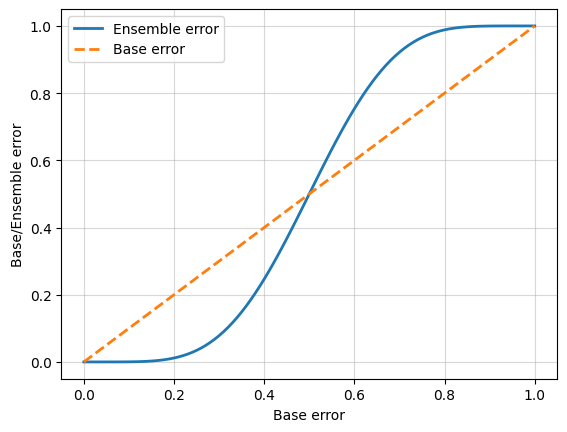

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error) for error in error_range]
plt.plot(error_range, ens_errors,
         label='Ensemble error',
         linewidth=2)
plt.plot(error_range, error_range, 
         linestyle='--', label='Base error',
         linewidth=2)
plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.show()

# Voting Classifiers





## Hard Voting (majority vote)

* Suppose you have trained a few classifiers: a logistic regression classifier, an SVM classifier, a random forest classifier, a k-nearest neighbors classifier, and perhaps a few more. 

* A very simple way to create an even better classifier is to aggregate the predictions of each classifier: the class that gets the most votes is the ensemble’s prediction. This majority-vote classifier is called a **hard voting classifier**.

* Scikit-Learn provides a `VotingClassifier` class that’s quite easy to use: just give it a list of name/predictor pairs, and use it like a normal classifier.

* When you fit a `VotingClassifier`, it clones every estimator and fits the clones. The original estimators are available via the `estimators` attribute, while the fitted clones are available via the `estimators_` attribute. If you prefer a dict rather than a list, you can use `named_estimators` or `named_estimators_` instead.

* When you call the voting classifier’s `predict()` method, it performs hard voting.

In [ ]:
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [ ]:
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
voting_clf = VotingClassifier(
        estimators=[
            ('lr', LogisticRegression(random_state=42)),
            ('rf', RandomForestClassifier(random_state=42)),
            ('svc', SVC(random_state=42))
] )
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [ ]:
for name, clf in voting_clf.named_estimators_.items():
  print(name, "=", clf.score(X_test, y_test))

lr = 0.864
rf = 0.896
svc = 0.896


In [ ]:
[clf.predict(X_test[:1]) for clf in voting_clf.estimators_]

[array([1]), array([1]), array([0])]

In [ ]:
# hard voting
voting_clf.predict(X_test[:1])

array([1])

In [ ]:
# performance of the voting classifier on the test set
voting_clf.score(X_test, y_test)

0.912

## Soft Voting (weighted majority vote based on class probabilities)

* If all classifiers are able to estimate class probabilities (i.e., if they all have a `predict_proba()` method), then you can tell Scikit-Learn to predict the class with the highest class probability, averaged over all the individual classifiers. This is called **soft voting**. It often achieves higher performance than hard voting because it gives more weight to highly confident votes.

* All you need to do is set the voting classifier’s voting hyperparameter to `"soft"`, and ensure that all classifiers can estimate class probabilities.

In [ ]:
voting_clf.voting = "soft"
voting_clf.named_estimators["svc"].probability = True

In [ ]:
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.92

# Bagging and Pasting

* Another way to get a diverse set of classifiers is to use the same training algorithm for every predictor but train them on different random subsets of the training set. 

* When sampling is performed with replacement, this method is called **bagging** (short for **bootstrap aggregating**). When sampling is performed without replacement, it is called **pasting**. Note that in statistics, resampling with replacement is called bootstrapping.

* **Scalability.** Bagging and pasting scale very well. Predictors can all be trained in parallel, via different CPU cores or even different servers. Similarly, predictions can be made in parallel.

* Once all predictors are trained, the ensemble can make a prediction for a new instance by simply aggregating the predictions of all predictors. 

 The aggregation function is typically the statistical **mode** for classification (i.e., the most frequent prediction, just like with a hard voting classifier), or the **average** for regression.

* **Bias and variance.** Each individual predictor has a higher bias than if it were trained on the original training set, but aggregation reduces both bias and variance.

 Generally, the net result is that the ensemble has a similar bias but a lower variance than a single predictor trained on the original training set.  

## Bagging and Pasting in Scikit-Learn

* Scikit-Learn offers a simple API for both bagging and pasting: `BaggingClassifier` class or `BaggingRegressor` for regression. 

* A `BaggingClassifier` automatically performs soft voting instead of hard voting if the base classifier can estimate class probabilities (i.e., if it has a `predict_proba()` method), which is the case with decision tree classifiers.

* We give below an example of bagging, but if you want to use pasting instead, just set `bootstrap=False`. 

* Bagging introduces a bit more diversity in the subsets that each predictor is trained on, so bagging ends up with a slightly higher bias than pasting; but the extra diversity also means that the predictors end up being less correlated, so the ensemble’s variance is reduced. 

 Overall, bagging often results in better models, which explains why it’s generally preferred. But if you have spare time and CPU power, you can use cross-validation to evaluate both bagging and pasting and select the one that works best.


In [ ]:
from sklearn.ensemble import BaggingClassifier 
from sklearn.tree import DecisionTreeClassifier

In [ ]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), 
                            n_estimators=500,
                            max_samples=100,
                            n_jobs=-1, # use all available CPU cores
                            random_state=42)
bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=42)

# Boosting: AdaBoost


* Boosting refers to any ensemble method that can combine several weak learners into a strong learner. The general idea of most boosting methods is to train predictors sequentially, each trying to correct its predecessor. 

* There are many boosting methods available, but by far the most popular are **AdaBoost** (short for adaptive boosting) and **gradient boosting**.

## AdaBoost overview

* The core principle of AdaBoost is to fit a sequence of weak learners (i.e., models that are only slightly better than random guessing, such as small decision trees) on repeatedly modified versions of the data. The predictions from all of them are then combined through a weighted majority vote (or sum) to produce the final prediction.

*  When training an AdaBoost classifier, the algorithm first trains a base classifier and uses it to make predictions on the training set. The algorithm then increases the relative weight of misclassified training instances. Then it trains a second classifier, using the updated weights, and again makes predictions on the training set, updates the instance weights, and so on.

* Once all predictors are trained, the ensemble makes predictions very much like bagging or pasting, except that predictors have different weights depending on their overall accuracy on the weighted training set.

* The more accurate the predictor is, the higher its weight will be. If it is just guessing randomly, then its weight will be close to zero. However, if it is most often wrong (i.e., less accurate than random guessing), then its weight will be negative.

* One important drawback to this sequential learning technique: **training cannot be parallelized** since each predictor can only be trained after the previous predictor has been trained and evaluated. As a result, it does not scale as well as bagging or pasting.

## AdaBoost training

* Each instance weight $w^{(i)}$ is initially set to $\frac{1}{m}$, where $m$ is the number of training examples.

* A first predictor is trained, and its **weighted error rate** $r_1$ is computed on the training set using the equation (with $j=1$):

$$r_j =  \sum_{\substack{i=1 \\ \widehat{y}_j^{(i)}\neq y^{(i)}}}^m w^{(i)} $$
  where $\widehat{y}_j^{(i)}$ is the $j$-th predictor's prediction for the $i$-th instance.

* Then the predictor's **weight** $\alpha_j$ is computed using the equation:

$$ \alpha_j = \eta \log \frac{1-r_j}{r_j}$$
where $\eta$ is the learning rate hyperparameter (defaults to 1).
    
* Next, the **instance weights** are updated, boosting the weights of the misclassified instances:

$$ w^{(i)} \leftarrow \begin{cases} w^{(i)} & \text{ if } \widehat{y}_j^{(i)} = y^{(i)} \\ w^{(i)}\exp(\alpha_j) & \text{ if } \widehat{y}_j^{(i)} \neq  y^{(i)}\end{cases}$$

* Then all the instance weights are normalized, i.e., divided by $\sum_{i=1}^m w^{(i)}.$

* Finally, a new predictor is trained using the updated weights, and the whole process is repeated: the new predictor’s weight is computed, the instance weights are updated, then another predictor is trained, and so on. 

* The algorithm stops when the desired number of predictors is reached, or when a perfect predictor is found.





## AdaBoost predictions

* To make predictions, AdaBoost simply computes the predictions of all the predictors and weighs them using the predictor weights $\alpha_j$. 

 The predicted class is the one that receives the majority of weighted votes:

$$\widehat{y}(\mathbf{x}) = \text{argmax} \sum_{\substack{j=1 \\ \widehat{y}_j^{(i)}(\mathbf{x}) = k}}^N \alpha_j$$
where $N$ is the number of predictions.




## AdaBoost in Scikit-Learn

* The following code trains an AdaBoost classifier based on 30 decision stumps (decision trees with max_depth=1) using Scikit-Learn’s `AdaBoostClassifier` class (as you might expect, there is also an AdaBoostRegressor class):


In [ ]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=30,
    learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=30, random_state=42)

In [ ]:
ada_clf.score(X_test, y_test)

0.904

## Multiclass AdaBoost: SAMME and SAMME.R

* Scikit-Learn uses a multiclass version of AdaBoost called **SAMME** (which stands for *Stagewise Additive Modeling using a Multiclass Exponential loss function*). 

 When there are just two classes, SAMME is equivalent to AdaBoost. 
 
*  If the predictors can estimate class probabilities, Scikit-Learn can use a variant of SAMME called **SAMME.R** (the R stands for “Real”), which relies on class probabilities rather than predictions and generally performs better.


# Boosting: Gradient Boosting

* Gradient boosting works by sequentially adding predictors to an ensemble, each one correcting its predecessor. However, instead of tweaking the instance weights at every iteration like AdaBoost does, this method tries to fit the new predictor to the residual errors made by the previous predictor.

# References:

* [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, by Aurélien Géron.](https://www.oreilly.com/library/view/hands-on-machine-learning/9781098125967/)

* [Machine Learning with PyTorch and Scikit-Learn, by Sebastian Raschka, Yuxi (Hayden) Liu,  Vahid Mirjalili](https://www.packtpub.com/product/machine-learning-with-pytorch-and-scikit-learn/9781801819312)

* https://scikit-learn.org/stable/modules/ensemble.html